# How to Run the Code

## Dependensies
Ensure the following Python libraries are installed:
- `numpy`
- `pandas`
- `matplotlib` (if you want to use `final.xy_plot`)
- Any custom modules like `final` should be available in the current Python environment.

## Prepare the Dataset
- `data_dict`: A dictionary where each entry contains the x and y data for FFT computation and plotting.

## Run the Code
- Place the code inside a Python script or a Jupyter Notebook.
- Execute the script to process each folder in `data_dict`.
- The code will:
- - Sort the data.
- - Compute the FFT and corresponding frequencies.
- - Append the FFT results \(frequencies and amplitudes\) to `data_dict`.
- - Plot the original data using `final.xy_plot`.

### Output
- The FFT data \(frequencies and amplitudes\) will be appended to each folder's entry in `data_dict`.
- Any errors or status updates will be printed during execution.

## Bibliography
1. NumPy Documentation:
- Used for understanding `np.fft.fft`, `np.fft.fftfreq`, and general array manipulations.
- Source: https://numpy.org/doc/stable/

2. Pandas Documentation:
- Used for creating and manipulating DataFrames.
- Source: https://pandas.pydata.org/docs/

3. Matplotlib Documentation:
- Referenced for plotting methods in `final.xy_plot`.
- Source: https://matplotlib.org/stable/contents.html

4. FFT Theory and Application:
- Used to understand FFT fundamentals and its practical application in signal processing.
- Source: Cooley, J. W., & Tukey, J. W. (1965). An algorithm for the machine calculation of complex Fourier series. Mathematics of Computation.

5. Custom Module (final):
- Assumed to contain helper functions like `final.fft` and `final.xy_plot`.

In [6]:
import sys
import os
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Paths to Algorithm and Data directories
alg_path = "/workspaces/CP1-24-final/HeshamElsaman/Code/Algorithm"
data_path = "/workspaces/CP1-24-final/HeshamElsaman/Data/GPSSine"
sys.path.append(alg_path)
sys.path.append(data_path)

# Import custom modules
import final
from mercator_projection_functions import xy_on_earth
importlib.reload(final)

<module 'final' from '/workspaces/CP1-24-final/HeshamElsaman/Code/Algorithm/final.py'>

In [7]:
# List and process folder data
folders_list = sorted(final.list_folders(data_path, "gps_sin"))
folders_dirs = [data_path + "/" + i for i in folders_list]
data_dict = {}

# Step 1: Read and process raw data
for folder in folders_list:
    dir = data_path + "/" + folder
    csv_path = dir + "/Raw Data.csv"
    md_path = dir + "/" + folder + ".md"

    x_list, y_list = final.xy_coord(csv_path)
    temp = final.read_temp(md_path)
    data_dict[folder] = [temp, [list(x_list)[3:36], list(y_list)[3:36]]]

# Convert coordinates to meters, set origin at (0, 0)
for folder in data_dict:
    x_data, y_data = data_dict[folder][1]
    x_data = [x - x_data[0] for x in x_data]  # Shift x-coordinates
    y_data = [y - y_data[0] for y in y_data]  # Shift y-coordinates
    data_dict[folder][1] = [[1000 * i for i in x_data], [1000 * j for j in y_data]]


In [8]:
print(data_dict)

{'gs01_gps_sin': [28.0, [[np.float64(0.0), np.float64(0.9017908578243805), np.float64(2.992255476783612), np.float64(4.321034852182493), np.float64(5.3951778427290265), np.float64(6.984153344092192), np.float64(8.143916429617093), np.float64(9.002341263112612), np.float64(10.068700610645465), np.float64(11.54536923422711), np.float64(12.885268102763803), np.float64(13.781499210381298), np.float64(13.75703632584191), np.float64(13.71255835510965), np.float64(13.565781053330284), np.float64(13.967194738143007), np.float64(14.707752949107089), np.float64(16.261146074612043), np.float64(17.722247410347336), np.float64(18.482820709323278), np.float64(19.38905936003721), np.float64(20.235252752172528), np.float64(21.377224649768323), np.float64(22.488061966214445), np.float64(23.885782195065985), np.float64(25.013298749399837), np.float64(24.88653653381334), np.float64(24.481787000695476), np.float64(23.810169643184054), np.float64(23.56220495857997), np.float64(23.32869561178086), np.float6

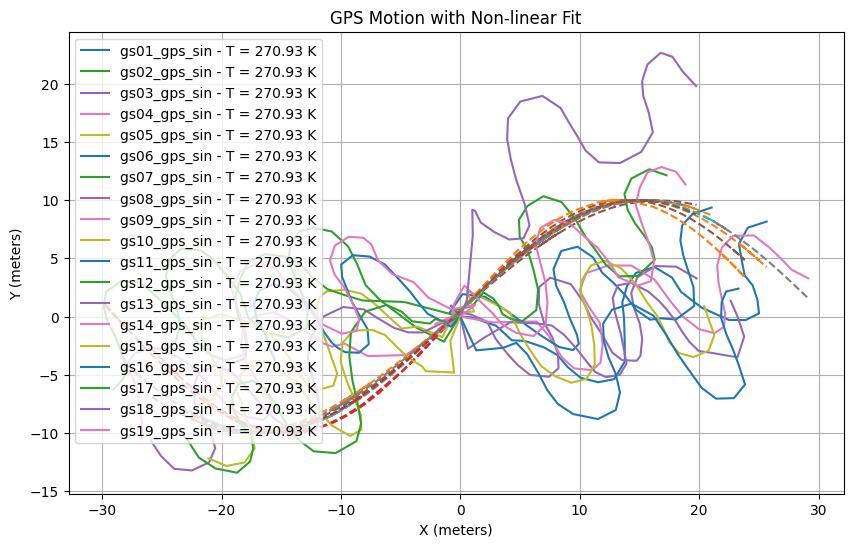

In [9]:
# Step 2: Generate GPS motion plot with fit
plt.figure(figsize=(10, 6))
for folder in folders_list:
    temp_k = final.fahrenheit_to_kelvin(data_dict[folder][0])
    x_data, y_data = data_dict[folder][1]

    # Fit sinusoidal data
    a0, b0, c0 = 10, 0.1, 0.05
    try:
        a, b, c = final.fit_sinusoidal(x_data, y_data, 20, (a0, b0, c0))
        y_fit = [a * np.sin(b * x + c) for x in x_data]
        plt.plot(x_data, y_data, label=f"{folder} - T = {temp_k:.2f} K")
        plt.plot(x_data, y_fit, linestyle='--')
    except Exception as e:
        print(f"Error fitting data for {folder}: {e}")

plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.title("GPS Motion with Non-linear Fit")
plt.legend()
plt.grid()
plt.show()

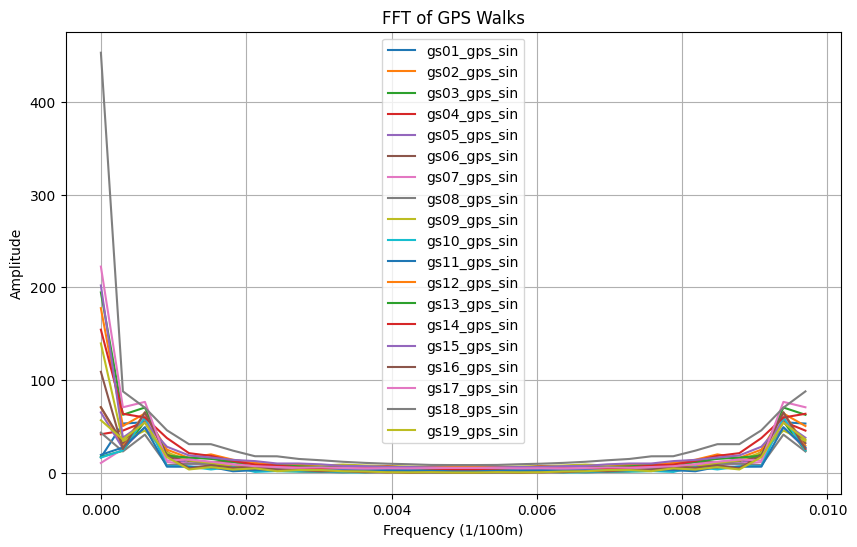

In [10]:
# Step 3: Compute FFT of each walk
plt.figure(figsize=(10, 6))
fft_results = {}
for folder in folders_list:
    x_data, y_data = data_dict[folder][1]
    df = pd.DataFrame({'x': x_data, 'y': y_data})

    # Perform FFT
    fft_series = final.fft(df, 'x', 'y')
    fft_frequencies = final.calculate_frequency_axis(0.010, len(x_data))
    fft_amplitudes = np.abs(fft_series)

    fft_results[folder] = (fft_frequencies, fft_amplitudes)
    plt.plot(fft_frequencies, fft_amplitudes, label=folder)

plt.xlabel("Frequency (1/100m)")
plt.ylabel("Amplitude")
plt.title("FFT of GPS Walks")
plt.legend()
plt.grid()
plt.show()


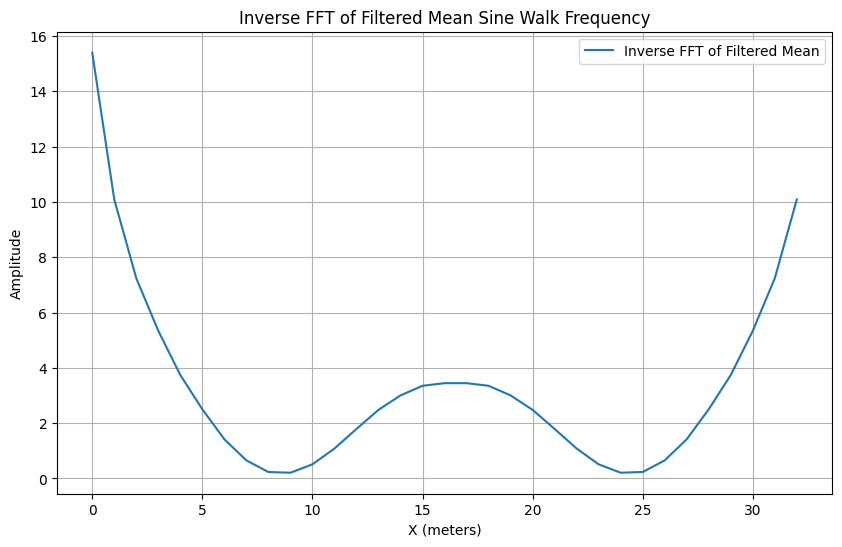

In [11]:
# Step 4: Compute inverse FFT of filtered mean frequency
mean_fft = np.mean([fft_results[folder][1] for folder in folders_list], axis=0)
frequencies = fft_results[folders_list[0]][0]

# Filter the mean FFT
filtered_mean_fft = np.where(frequencies < 0.1, mean_fft, 0)

# Perform inverse FFT
inverse_fft = np.fft.ifft(filtered_mean_fft)
plt.figure(figsize=(10, 6))
plt.plot(np.real(inverse_fft), label="Inverse FFT of Filtered Mean")
plt.xlabel("X (meters)")
plt.ylabel("Amplitude")
plt.title("Inverse FFT of Filtered Mean Sine Walk Frequency")
plt.legend()
plt.grid()
plt.show()
